In [ ]:
from sklearn.naive_bayes import CategoricalNB
from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import OrdinalEncoder
from sklearn.model_selection import train_test_split
from sklearn.metrics import *
import pandas as pd
import numpy as np
from sklearn.tree import DecisionTreeClassifier, export_graphviz
import pyAgrum as gum
import pyAgrum.lib.explain as explain
from sklearn.dummy import DummyClassifier
import pyAgrum.lib.notebook as gnb
import pyAgrum.lib.bn_vs_bn as bnvsbn

In [ ]:
df = pd.read_csv('https://raw.githubusercontent.com/ImagineDogs/TranstornosMentais/main/dados/df_cid10.csv')
diagnosticos = df[['cid10_faixa', 'cid10_faixa_alta', 'cid10_seg_faixa', 'sexo', 'faixa_etaria', 'etnia', 'qtd_internacoes', 'traumatismo',
                        'prob_respiratorios', 'avc', 'convulsao', 'has','gravidez', 'diabetes', 'doenca_infecto']].loc[~df['cid10_faixa'].isnull()]
diagnosticos = diagnosticos.fillna('Sem')

In [ ]:
df_train, df_test = train_test_split(diagnosticos, train_size = 0.8, random_state=42)

In [ ]:
template = gum.BayesNet('Plus')
labels = ['cid10_faixa', 'cid10_faixa_alta', 'cid10_seg_faixa', 'sexo', 'faixa_etaria', 'etnia', 'qtd_internacoes', 'traumatismo', 'prob_respiratorios', 'avc', 'convulsao', 'has','gravidez', 'diabetes']
for i in labels:
  if diagnosticos[i].dtypes == 'int64':
    template.add(gum.IntegerVariable(i, "", diagnosticos[i].unique().tolist()))
  else:
    template.add(gum.LabelizedVariable(i, "", diagnosticos[i].unique().tolist()))
template

(pyAgrum.BayesNet<double>@000001C7E8371520) BN{nodes: 14, arcs: 0, domainSize: 10^9.85975, dim: 79, mem: 744o}

Naive Bayes sem dados de treino

In [ ]:
labels2 = labels.copy()
labels2.remove('cid10_faixa_alta')

alta = ''
for j in diagnosticos['cid10_faixa_alta'].unique():
  alta += '|' + str(j)
alta = 'cid10_faixa_alta{' + alta[1:] + '}'

conections = ''
for i in labels2:
  label = ''
  for j in diagnosticos[i].unique():
    label += '|' + str(j)
  label = i + '{' + label[1:] + '}'

  conections += f'{label}<-{alta};'
bn=gum.fastBN(conections)
gnb.showBN(bn)

In [ ]:
conections

'cid10_faixa{F10-F19|F60-F69|F30-F39|F70-F79|F20-F29|F01-F09|F40-F49|F90-F98|F99-F99|F50-F59|F80-F89}<-cid10_faixa_alta{F10-F19|F60-F69|F30-F39|F01-F09|F20-F29|F70-F79|Sem|F90-F98|F40-F49|F99-F99|F50-F59|F80-F89};cid10_seg_faixa{Sem|F60-F69|F10-F19|F30-F39|F20-F29|F01-F09|F70-F79|F40-F49|F50-F59|F90-F98|F80-F89|F99-F99}<-cid10_faixa_alta{F10-F19|F60-F69|F30-F39|F01-F09|F20-F29|F70-F79|Sem|F90-F98|F40-F49|F99-F99|F50-F59|F80-F89};sexo{F|M|T}<-cid10_faixa_alta{F10-F19|F60-F69|F30-F39|F01-F09|F20-F29|F70-F79|Sem|F90-F98|F40-F49|F99-F99|F50-F59|F80-F89};faixa_etaria{40-49|30-39|60-69|15-19|20-29|50-59|Sem|10-14|70-79|0-9|>80}<-cid10_faixa_alta{F10-F19|F60-F69|F30-F39|F01-F09|F20-F29|F70-F79|Sem|F90-F98|F40-F49|F99-F99|F50-F59|F80-F89};etnia{BRANCO|PARDO|NEGRO|NAO INFORMADO|AMARELO}<-cid10_faixa_alta{F10-F19|F60-F69|F30-F39|F01-F09|F20-F29|F70-F79|Sem|F90-F98|F40-F49|F99-F99|F50-F59|F80-F89};qtd_internacoes{8|4|2|3|5|12|13|1|6|15|7|10|18|14|9|20|16|17|11}<-cid10_faixa_alta{F10-F19|F60-F69|F

Naive Bayes com dados de treino

In [ ]:
learner = gum.BNLearner(df_train, bn)
bn1 = learner.learnParameters(bn.dag())
bn1

(pyAgrum.BayesNet<double>@000001C7E836F860) BN{nodes: 14, arcs: 13, domainSize: 10^9.85975, dim: 827, mem: 7Ko 704o}

Rede encontrada a partir dos dados de treino

In [ ]:
learner = gum.BNLearner(df_train, template)
bn2 = learner.learnBN()
bn2

(pyAgrum.BayesNet<double>@000001C7E83720A0) BN{nodes: 14, arcs: 12, domainSize: 10^9.85975, dim: 377, mem: 3Ko 608o}

Rede encontrada a partir dos dados de treino com conexões obrigatórias

In [ ]:
learner = gum.BNLearner(df_train, template)
learner.addMandatoryArc('cid10_seg_faixa', 'cid10_faixa_alta')
learner.addMandatoryArc('sexo', 'cid10_faixa_alta')
learner.addMandatoryArc('cid10_faixa', 'cid10_faixa_alta')

bn3 = learner.learnBN()
bn3

(pyAgrum.BayesNet<double>@000001C7E67DE790) BN{nodes: 14, arcs: 13, domainSize: 10^9.85975, dim: 4590, mem: 39Ko 376o}

Classificador

In [ ]:
import pyAgrum.skbn as skbn

In [ ]:
y_train = df_train['cid10_faixa_alta']
X_train = df_train.drop(['cid10_faixa_alta'], axis=1)
y_test = df_test['cid10_faixa_alta']
X_test = df_test.drop(['cid10_faixa_alta'], axis=1)

In [ ]:
scoreAll = pd.DataFrame()

Naive Bayes sem treinamento

In [ ]:
bnc=skbn.BNClassifier()
bnc.fromTrainedModel(bn,targetAttribute="cid10_faixa_alta")
print(f"Binary classifier : {bnc.isBinaryClassifier}")
gnb.showBN(bnc.MarkovBlanket)
print(f"predicted : {list(bnc.predict(X_test))}")
print(f"in base   : {y_test.to_list()}")
scoreCSV1 = bnc.score(X_test, y = y_test)
print("{0:.2f}% good predictions".format(100*scoreCSV1))
scoreAll['Naive Bayes sem treinamento'] = pd.Series(scoreCSV1)

Binary classifier : False


predicted : ['F70-F79', 'F40-F49', 'F70-F79', 'F01-F09', 'Sem', 'F40-F49', 'F50-F59', 'F40-F49', 'Sem', 'F40-F49', 'F99-F99', 'Sem', 'F70-F79', 'F01-F09', 'F40-F49', 'F40-F49', 'F50-F59', 'F40-F49', 'F40-F49', 'F70-F79', 'F40-F49', 'F90-F98', 'F50-F59', 'Sem', 'F70-F79', 'F70-F79', 'F99-F99', 'Sem', 'F90-F98', 'F50-F59', 'F50-F59', 'F70-F79', 'F40-F49', 'F70-F79', 'F40-F49', 'F01-F09', 'F40-F49', 'Sem', 'F01-F09', 'Sem', 'Sem', 'F50-F59', 'F40-F49', 'F70-F79', 'Sem', 'F50-F59', 'F50-F59', 'F90-F98', 'F01-F09', 'F50-F59', 'F01-F09', 'F70-F79', 'F99-F99', 'F40-F49', 'F70-F79', 'F40-F49', 'F01-F09', 'F40-F49', 'F70-F79', 'F50-F59', 'F50-F59', 'F50-F59', 'F70-F79', 'F01-F09', 'Sem', 'F01-F09', 'F01-F09', 'F40-F49', 'F70-F79', 'F50-F59', 'F70-F79', 'F70-F79', 'F40-F49', 'F40-F49', 'Sem', 'F50-F59', 'F01-F09', 'F50-F59', 'F70-F79', 'F70-F79', 'F70-F79', 'F50-F59', 'F40-F49', 'F01-F09', 'F01-F09', 'F90-F98', 'F40-F49', 'F01-F09', 'F50-F59', 'Sem', 'Sem', 'F90-F98', 'F70-F79', 'F50-F59', 'F01-

Naive Bayes com treinamento

In [ ]:
bnc=skbn.BNClassifier()
bnc.fromTrainedModel(bn1,targetAttribute="cid10_faixa_alta")
print(f"Binary classifier : {bnc.isBinaryClassifier}")
gnb.showBN(bnc.MarkovBlanket)
print(f"predicted : {list(bnc.predict(X_test))}")
print(f"in base   : {y_test.to_list()}")
scoreCSV1 = bnc.score(X_test, y = y_test)
print("{0:.2f}% good predictions".format(100*scoreCSV1))
scoreAll['Naive Bayes com treinamento'] = pd.Series(scoreCSV1)

Binary classifier : False


predicted : ['F30-F39', 'F10-F19', 'F10-F19', 'F10-F19', 'F20-F29', 'F30-F39', 'F20-F29', 'F30-F39', 'F10-F19', 'F30-F39', 'F30-F39', 'F10-F19', 'F10-F19', 'F10-F19', 'F10-F19', 'F30-F39', 'F20-F29', 'F20-F29', 'F20-F29', 'F90-F98', 'F20-F29', 'F60-F69', 'F20-F29', 'F70-F79', 'F10-F19', 'F10-F19', 'F10-F19', 'F20-F29', 'F60-F69', 'F10-F19', 'F20-F29', 'F10-F19', 'F20-F29', 'F20-F29', 'F20-F29', 'F10-F19', 'F30-F39', 'F30-F39', 'F10-F19', 'F30-F39', 'F10-F19', 'F20-F29', 'F30-F39', 'F20-F29', 'F10-F19', 'F10-F19', 'Sem', 'F30-F39', 'F10-F19', 'F20-F29', 'F30-F39', 'F20-F29', 'F40-F49', 'F20-F29', 'F30-F39', 'F30-F39', 'F10-F19', 'F40-F49', 'F20-F29', 'F30-F39', 'F20-F29', 'F60-F69', 'F10-F19', 'F10-F19', 'F30-F39', 'F10-F19', 'F10-F19', 'F30-F39', 'F20-F29', 'F30-F39', 'F10-F19', 'F10-F19', 'F10-F19', 'F30-F39', 'F30-F39', 'F10-F19', 'F10-F19', 'F10-F19', 'F30-F39', 'F40-F49', 'F10-F19', 'F20-F29', 'F30-F39', 'F20-F29', 'F10-F19', 'F30-F39', 'F30-F39', 'F10-F19', 'F30-F39', 'F30-F39', '

Rede econtrada pelo treinamento

Binary classifier : False


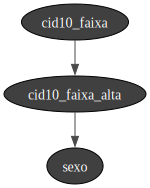

predicted : ['F30-F39', 'F10-F19', 'F10-F19', 'F10-F19', 'F20-F29', 'F30-F39', 'F20-F29', 'F30-F39', 'F10-F19', 'F30-F39', 'F30-F39', 'F10-F19', 'F10-F19', 'F10-F19', 'F30-F39', 'F30-F39', 'F20-F29', 'F20-F29', 'F20-F29', 'F70-F79', 'F20-F29', 'F60-F69', 'F20-F29', 'F70-F79', 'F10-F19', 'F10-F19', 'F10-F19', 'F20-F29', 'F60-F69', 'F10-F19', 'F20-F29', 'F10-F19', 'F20-F29', 'F20-F29', 'F20-F29', 'F10-F19', 'F30-F39', 'F30-F39', 'F10-F19', 'F30-F39', 'F10-F19', 'F20-F29', 'F30-F39', 'F20-F29', 'F10-F19', 'F60-F69', 'F20-F29', 'F20-F29', 'F10-F19', 'F20-F29', 'F10-F19', 'F20-F29', 'F40-F49', 'F20-F29', 'F30-F39', 'F30-F39', 'F10-F19', 'F40-F49', 'F20-F29', 'F20-F29', 'F20-F29', 'F60-F69', 'F10-F19', 'F10-F19', 'F30-F39', 'F10-F19', 'F10-F19', 'F30-F39', 'F20-F29', 'F30-F39', 'F10-F19', 'F10-F19', 'F10-F19', 'F30-F39', 'F30-F39', 'F10-F19', 'F10-F19', 'F10-F19', 'F30-F39', 'F40-F49', 'F10-F19', 'F20-F29', 'F30-F39', 'F70-F79', 'F10-F19', 'F30-F39', 'F30-F39', 'F10-F19', 'F30-F39', 'F30-F39

In [ ]:
bnc=skbn.BNClassifier()
bnc.fromTrainedModel(bn2,targetAttribute="cid10_faixa_alta")
print(f"Binary classifier : {bnc.isBinaryClassifier}")
gnb.showBN(bnc.MarkovBlanket)
print(f"predicted : {list(bnc.predict(X_test))}")
print(f"in base   : {y_test.to_list()}")
scoreCSV1 = bnc.score(X_test, y = y_test)
print("{0:.2f}% good predictions".format(100*scoreCSV1))
scoreAll['Rede econtrada pelo treinamento'] = pd.Series(scoreCSV1)

Rede encontrada pelo treinamento, com conexões obrigatórias

Binary classifier : False


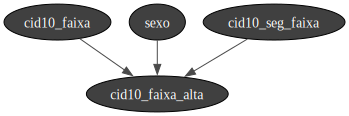

predicted : ['F30-F39', 'F10-F19', 'F10-F19', 'F10-F19', 'F20-F29', 'F30-F39', 'F20-F29', 'F30-F39', 'F10-F19', 'F30-F39', 'F30-F39', 'F10-F19', 'F10-F19', 'F10-F19', 'F30-F39', 'F30-F39', 'F20-F29', 'F20-F29', 'F20-F29', 'F70-F79', 'F20-F29', 'F60-F69', 'F20-F29', 'F70-F79', 'F10-F19', 'F10-F19', 'F10-F19', 'F20-F29', 'F60-F69', 'F10-F19', 'F20-F29', 'F10-F19', 'F20-F29', 'F20-F29', 'F20-F29', 'F10-F19', 'F30-F39', 'F30-F39', 'F10-F19', 'F30-F39', 'F10-F19', 'F20-F29', 'F30-F39', 'F20-F29', 'F10-F19', 'F60-F69', 'F20-F29', 'F20-F29', 'F10-F19', 'F20-F29', 'F10-F19', 'F20-F29', 'F40-F49', 'F20-F29', 'F30-F39', 'F30-F39', 'F10-F19', 'F40-F49', 'F20-F29', 'F20-F29', 'F20-F29', 'F60-F69', 'F10-F19', 'F10-F19', 'F30-F39', 'F10-F19', 'F10-F19', 'F30-F39', 'F20-F29', 'F30-F39', 'F10-F19', 'F10-F19', 'F10-F19', 'F30-F39', 'F30-F39', 'F10-F19', 'F10-F19', 'F10-F19', 'F30-F39', 'F40-F49', 'F10-F19', 'F20-F29', 'F30-F39', 'F70-F79', 'F10-F19', 'F30-F39', 'F30-F39', 'F10-F19', 'F30-F39', 'F30-F39

In [ ]:
bnc=skbn.BNClassifier()
bnc.fromTrainedModel(bn3,targetAttribute="cid10_faixa_alta")
print(f"Binary classifier : {bnc.isBinaryClassifier}")
gnb.showBN(bnc.MarkovBlanket)
print(f"predicted : {list(bnc.predict(X_test))}")
print(f"in base   : {y_test.to_list()}")
scoreCSV1 = bnc.score(X_test, y = y_test)
print("{0:.2f}% good predictions".format(100*scoreCSV1))
scoreAll['Rede encontrada pelo treinamento, com conexões obrigatórias'] = pd.Series(scoreCSV1)

In [ ]:
scoreAll

,Naive Bayes sem treinamento,Naive Bayes com treinamento,Rede econtrada pelo treinamento,"Rede encontrada pelo treinamento, com conexões obrigatórias"
0,0.026156,0.705596,0.737835,0.740876


bayesian_data/X_test.csv: 100%|██████████|


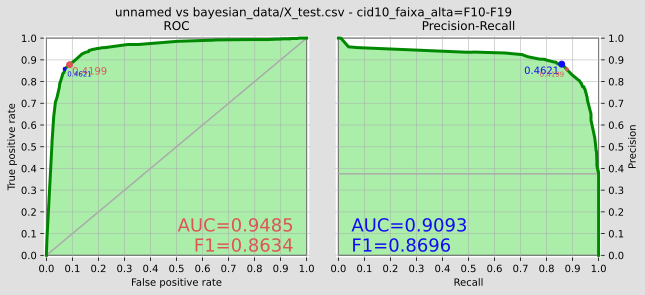

(0.9485290984583189, 0.41994892945, 0.9093314353009152, 0.4621416787)

In [ ]:
from pyAgrum.lib.bn2roc import showROC_PR
showROC_PR(bn3, "bayesian_data/X_test.csv", 'cid10_faixa_alta', "F10-F19", show_progress=True, show_fig=True)

In [ ]:
def NameFromId(graph, id):
    node = graph.variable(id)
    return node.name()

In [ ]:
def search(graph, top, bottom):
    topfound = []
    pathfound = []
    flag = False

    # Pega todos os pais do nó dado
    parent = graph.parents(bottom)

    # Caso não possua pais e o nó é encontrado
    if parent == set() and bottom in top:
        return [], [bottom], True

    # Caso não possua pais e o nó não é encontrado
    elif parent == set() and bottom not in top:
        return [], [], False

    # Caso possua pais
    elif parent != set():

        # Caso o nó seja encontrado
        if bottom in top:
            topfound = set([bottom]) | set(topfound)
            flag = True

        # Continua a busca para os pais do nó encontrado
        i = 0
        for node in parent:

            i += 1
            auxpath, auxtop, flag2 = search(graph, top, node)

            # Monta o caminho seguido
            pathfound = set(auxpath) | set(pathfound)

            # Se o nó em especifico fizer parte do caminho de um nó encontrado ele é contabilizado no caminho
            if flag2:
                pathfound = set(pathfound) | set([node])

            topfound = set(auxtop) | set(topfound)

        if flag2:
            flag = True
        return pathfound, topfound, flag
    print('d')
    return pathfound, topfound, flag


In [ ]:
# Cria um subgrafo de uma rede passada
def subgraph(graph, top=[], bottom = None):
    if type(graph) == gum.BayesNet:
        g_aux = gum.BayesNet(graph)

        top = list(map(g_aux.idFromName, top))
        bottom = g_aux.idFromName(bottom)
        if bottom == None:
            return 'Colocar último'

        # Encontra os ids validos para subgrafo
        id_nos_validos = search(g_aux, top, bottom)[0]
        id_nos_validos = list(id_nos_validos)
        id_nos_validos.extend([bottom])

        nome_nos_validos = list(map(NameFromId, [g_aux]*len(id_nos_validos), id_nos_validos))
        # print('Nós Válidos', nome_nos_validos)

        # Criacao do subgrafo
        eliminar = set(g_aux.names()).difference(set(nome_nos_validos))
        for node in eliminar:
            g_aux.erase(node)
        return g_aux

    else:
        print('Passar Rede Bayesiana')


In [ ]:
# Funcao para retornar a inferencia com grafo reduzido
# Parametros:
#   Grafo: Grafo a ser utilizado na inferencia
#   Evs: Eventos a serem inferenciados. Molde -> {Variavel, ValorAssumido}
#   Nó Investigado: Nó alvo para ser investigado (Último)
def inferencia(graph, evs, no_investigado):
    topos = evs.keys()
    graph = subgraph(graph, topos, no_investigado)
    inf = gnb.getInference(graph, evs = evs)
    return inf

In [ ]:
#  Analisando o impacto do sexo no diagnóstico

inf1 = inferencia(bn3, evs = {'sexo': 'M'}, no_investigado = 'cid10_faixa_alta')
inf2 = inferencia(bn3, evs = {'sexo': 'F'}, no_investigado = 'cid10_faixa_alta')
inf3 = inferencia(bn3, evs = {'sexo': 'T'}, no_investigado = 'cid10_faixa_alta')
gnb.flow.row(inf1, inf2, inf3)

In [ ]:
gnb.flow.row(gnb.getInference(bn3, evs = {'sexo': 'F'}))

In [ ]:
#  Analisando o impacto da hipertensão arterial sistêmica (has) no diagnóstico

inf1 = inferencia(bn3, evs = {'has': 'NAO'}, no_investigado = 'cid10_faixa_alta')
inf2 = inferencia(bn3, evs = {'has': 'SIM'}, no_investigado = 'cid10_faixa_alta')
inf3 = inferencia(bn3, evs = {'has': 'NAO INFORMADO'}, no_investigado = 'cid10_faixa_alta')
gnb.flow.row(inf1, inf2, inf3)

In [ ]:
# Analisando o impacto de problemas respiratórios no diagnóstico

inf1 = inferencia(bn3, evs = {'prob_respiratorios': 'NAO'}, no_investigado = 'cid10_faixa_alta')
inf2 = inferencia(bn3, evs = {'prob_respiratorios': 'SIM'}, no_investigado = 'cid10_faixa_alta')
inf3 = inferencia(bn3, evs = {'prob_respiratorios': 'NAO INFORMADO'}, no_investigado = 'cid10_faixa_alta')
gnb.flow.row(inf1, inf2, inf3)

In [ ]:
# Analisando o impacto conjunto de problemas respiratórios e hipertensão arterial sistêmica (has) no diagnóstico

inf1 = inferencia(bn3, evs = {'prob_respiratorios': 'NAO', 'has': "NAO"}, no_investigado = 'cid10_faixa_alta')
inf2 = inferencia(bn3, evs = {'prob_respiratorios': 'NAO', 'has': "SIM"}, no_investigado = 'cid10_faixa_alta')
inf3 = inferencia(bn3, evs = {'prob_respiratorios': 'SIM', 'has': "NAO"}, no_investigado = 'cid10_faixa_alta')
inf4 = inferencia(bn3, evs = {'prob_respiratorios': 'SIM', 'has': "SIM"}, no_investigado = 'cid10_faixa_alta')
gnb.flow.row(inf1, inf2, inf3, inf4)

In [ ]:
# Analisando o impacto do traumatismo no diagnóstico

inf1 = inferencia(bn3, evs = {'traumatismo': 'NAO'}, no_investigado = 'cid10_faixa_alta')
inf2 = inferencia(bn3, evs = {'traumatismo': 'SIM'}, no_investigado = 'cid10_faixa_alta')
inf3 = inferencia(bn3, evs = {'traumatismo': 'NAO INFORMADO'}, no_investigado = 'cid10_faixa_alta')
gnb.flow.row(inf1, inf2, inf3)

In [ ]:
# Analisando o impacto conjunto de traumatismo e problemas respiratórios no diagnóstico

inf1 = inferencia(bn3, evs = {'traumatismo': 'NAO', 'prob_respiratorios': "NAO"}, no_investigado = 'cid10_faixa_alta')
inf2 = inferencia(bn3, evs = {'traumatismo': 'NAO', 'prob_respiratorios': "SIM"}, no_investigado = 'cid10_faixa_alta')
inf3 = inferencia(bn3, evs = {'traumatismo': 'SIM', 'prob_respiratorios': "NAO"}, no_investigado = 'cid10_faixa_alta')
inf4 = inferencia(bn3, evs = {'traumatismo': 'SIM', 'prob_respiratorios': "SIM"}, no_investigado = 'cid10_faixa_alta')
gnb.flow.row(inf1, inf2, inf3, inf4)

In [ ]:
# Analisando o impacto conjunto de traumatismo e hipertensão arterial sistêmica (has) no diagnóstico

inf1 = inferencia(bn3, evs = {'traumatismo': 'NAO', 'has': "NAO"}, no_investigado = 'cid10_faixa_alta')
inf2 = inferencia(bn3, evs = {'traumatismo': 'NAO', 'has': "SIM"}, no_investigado = 'cid10_faixa_alta')
inf3 = inferencia(bn3, evs = {'traumatismo': 'SIM', 'has': "NAO"}, no_investigado = 'cid10_faixa_alta')
inf4 = inferencia(bn3, evs = {'traumatismo': 'SIM', 'has': "SIM"}, no_investigado = 'cid10_faixa_alta')
gnb.flow.row(inf1, inf2, inf3, inf4)